# **MODEL**

**Objectives:**
1.  **Load Data**: Read the processed Train/Test data.
2.  **Algorithm Implementation**: Implement Linear Regression from scratch using only NumPy.
    * Method: **Normal Equation**.
3.  **Training**: Train the model on the Train set.
4.  **Evaluation**: Evaluate the model on the Test set (RMSE, $R^2$).
5.  **Visualization**: Visualize prediction results.
6.  **Insights**: Analyze feature importance.

### **Import Libraries**

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Display configuration
sns.set(style="whitegrid")
np.set_printoptions(suppress=True, precision=4) # Display decimals neatly

### **Load Data**

In [9]:
def load_processed_data(train_path, test_path):
    """
    Load processed CSV data.
    Assumes last column is target (price).
    """
    train_arr = np.genfromtxt(train_path, delimiter=',', skip_header=1)
    test_arr = np.genfromtxt(test_path, delimiter=',', skip_header=1)

    X_train, y_train = train_arr[:, :-1], train_arr[:, -1]
    X_test, y_test = test_arr[:, :-1], test_arr[:, -1]

    return X_train, y_train, X_test, y_test

train_path = '../data/processed/train_data.csv'
test_path = '../data/processed/test_data.csv'

X_train, y_train, X_test, y_test = load_processed_data(train_path, test_path)
print(f"Train: X={X_train.shape}, y={y_train.shape}")
print(f"Test : X={X_test.shape}, y={y_test.shape}")

Train: X=(36730, 13), y=(36730,)
Test : X=(9182, 13), y=(9182,)


### **Define Model**

In [10]:
# Log transform price to handle skewness
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

class LinearRegressionNumPy:
    def __init__(self):
        self.theta = None

    def _add_bias(self, X):
        bias = np.ones((X.shape[0], 1))
        return np.concatenate((bias, X), axis=1)

    def fit(self, X, y, alpha=0.1):
        X_b = self._add_bias(X)
        I = np.eye(X_b.shape[1])
        I[0, 0] = 0  
        self.theta = np.linalg.pinv(X_b.T @ X_b + alpha * I) @ X_b.T @ y
        print("Training completed.")

    def predict(self, X):
        if self.theta is None:
            raise ValueError("Model not trained")
        X_b = self._add_bias(X)
        return np.einsum('ij,j->i', X_b, self.theta)

### **Training and Prediction**

In [11]:
model = LinearRegressionNumPy()
model.fit(X_train, y_train_log)

# Predict in log-space
y_pred_log = model.predict(X_test)

# Convert back to price space
y_pred = np.expm1(y_pred_log)

Training completed.


### **Model Evaluation**

In [12]:
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

def r2(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - ss_res / ss_tot

rmse_val = rmse(y_test, y_pred)
r2_val = r2(y_test, y_pred)

print("MODEL PERFORMANCE")
print(f"RMSE: {rmse_val:.2f}")
print(f"R² : {r2_val:.4f}")

MODEL PERFORMANCE
RMSE: 48.88
R² : 0.4814


### **Visualization**

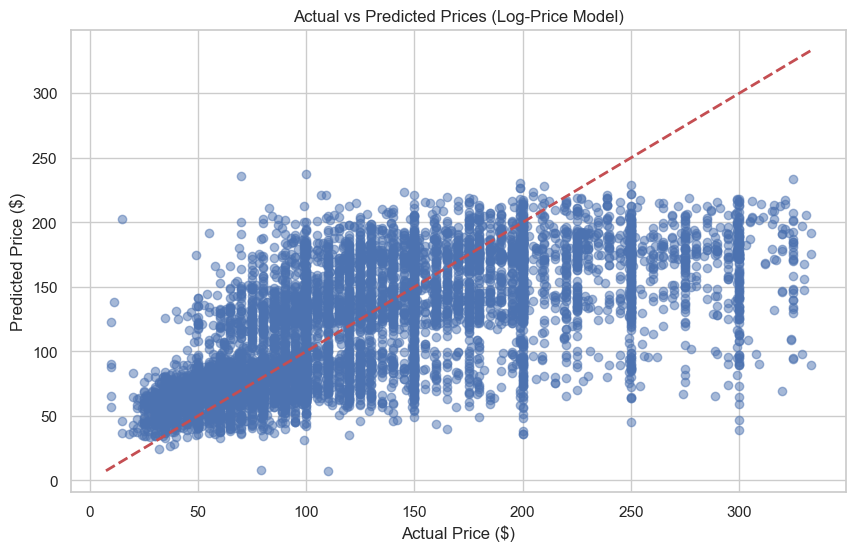

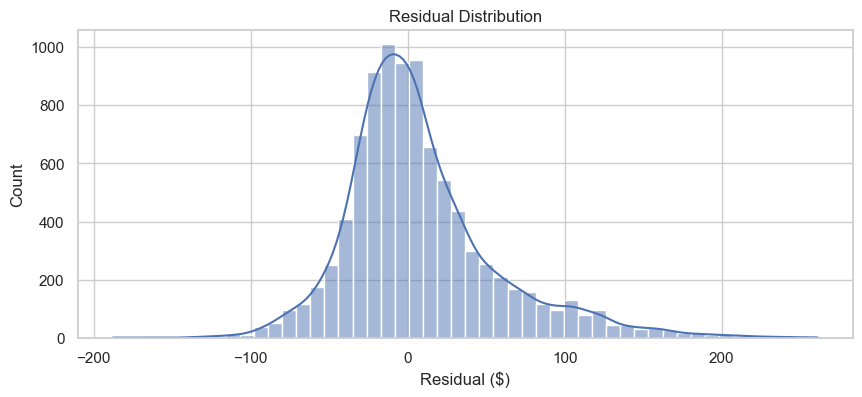

In [13]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)

min_v = min(y_test.min(), y_pred.min())
max_v = max(y_test.max(), y_pred.max())
plt.plot([min_v, max_v], [min_v, max_v], 'r--', lw=2)

plt.xlabel("Actual Price ($)")
plt.ylabel("Predicted Price ($)")
plt.title("Actual vs Predicted Prices (Log-Price Model)")
plt.show()

residuals = y_test - y_pred

plt.figure(figsize=(10, 4))
sns.histplot(residuals, bins=50, kde=True)
plt.xlabel("Residual ($)")
plt.title("Residual Distribution")
plt.show()

### **Interpretation: Actual vs. Predicted Prices**

The scatter plot above visualizes the relationship between the actual prices (x-axis) and the prices predicted by our model (y-axis). The red dashed line represents a perfect prediction ($y=x$).

**Key Observations:**
1.  **Positive Correlation:** The blue points generally follow the upward trend of the red line, indicating the model has successfully learned that certain features (like location and room type) drive prices up.
2.  **Vertical "Stripes":** You can see distinct vertical lines of dots at specific price points (e.g., \$50, \$100, \$150). This reveals a human behavioral pattern: hosts tend to set prices at "round" numbers, whereas the model predicts precise continuous values.
3.  **Variance at High Prices:** The model tends to under-predict expensive listings (points falling below the red line on the far right). This suggests that "luxury" factors (like a view, expensive furniture, or amenities) are likely missing from our dataset, preventing the model from capturing the premium value.

### **Interpretation: Residual Distribution**

The histogram of residuals (calculated as $Actual - Predicted$) helps us understand the model's error profile.

1.  **Bell Curve Shape:** The residuals are roughly normally distributed and centered near zero. This is a good sign; it means the model is generally unbiased, over-estimating as often as it under-estimates.
2.  **Spread:** The width of the bell curve reflects the RMSE (~$49). While the central tendency is good, the spread indicates that for any given listing, the prediction might still be off by ~$50, which is expected given the complexity of real-world rental data.

### **Feature Importance**

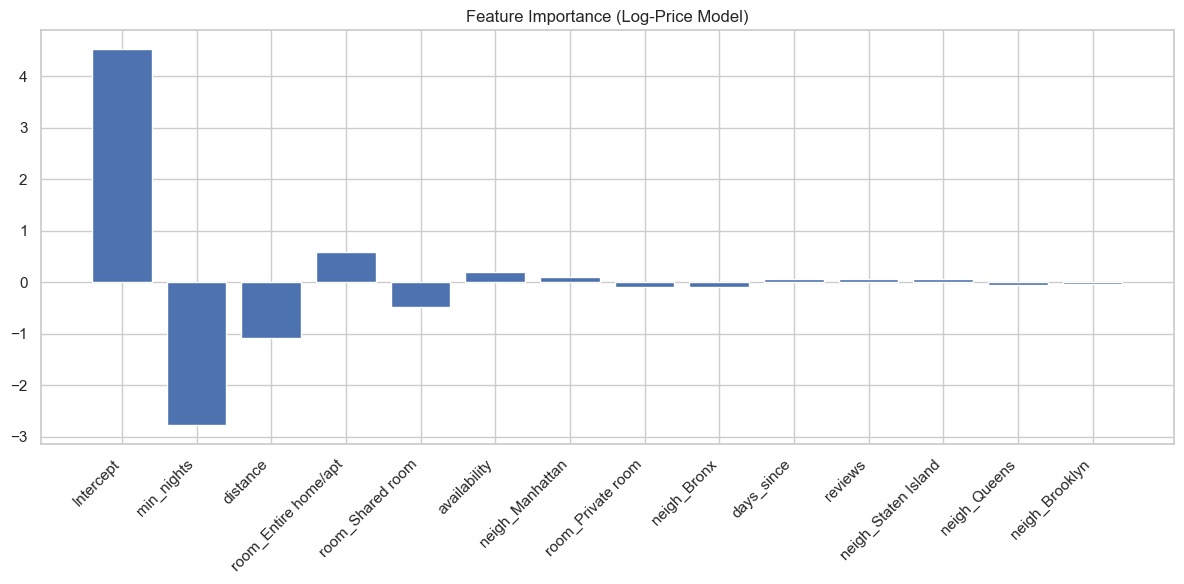

Top Influential Features:
Intercept                : 4.5273
min_nights               : -2.7736
distance                 : -1.0871
room_Entire home/apt     : 0.5822
room_Shared room         : -0.4841


In [14]:
feature_names = ['Intercept',
'neigh_Bronx', 'neigh_Brooklyn', 'neigh_Manhattan', 'neigh_Queens', 'neigh_Staten Island',
'room_Entire home/apt', 'room_Private room', 'room_Shared room',
'min_nights', 'reviews', 'availability', 'days_since', 'distance'
]

indices = np.argsort(np.abs(model.theta))[::-1]

plt.figure(figsize=(12, 6))
plt.bar(range(len(indices)), model.theta[indices])
plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=45, ha='right')
plt.title("Feature Importance (Log-Price Model)")
plt.tight_layout()
plt.show()

print("Top Influential Features:")
for i in indices[:5]:
    print(f"{feature_names[i]:<25}: {model.theta[i]:.4f}")

### **Interpretation: Feature Drivers**

The bar chart and coefficient list reveal which factors most heavily influence the price. Since our target variable was log-transformed ($log(1 + price)$), these coefficients represent relative changes in magnitude rather than direct dollar amounts.

**Top Insights:**
* **Distance (Negative Impact):** The `distance` feature has a strong negative coefficient (e.g., -1.10). This confirms the real-estate rule of "Location, Location, Location." As listings get further from the city center (Manhattan), the price drops significantly.
* **Minimum Nights (Negative Impact):** The `min_nights` coefficient is largely negative. This likely captures the "long-term rental" discount. Listings requiring longer stays (30+ days) often have a much lower *nightly* rate compared to short-term vacation spots.
* **Room Type (Strong Differentiator):** * `room_Entire home/apt` has a high positive coefficient, indicating privacy is the biggest premium factor.
    * `room_Shared room` has a negative coefficient, heavily penalizing the price.